In [32]:
# import
import pandas as pd
import numpy as np
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis

In [2]:
# all data
dia_df = pd.read_csv("data/DIA.csv")
qqq_df = pd.read_csv("data/QQQ.csv")
spy_df = pd.read_csv("data/SPY.csv")

# adding suffix to all df
dia_df.columns=dia_df.columns.map(lambda x : x+'_dia' if x !='Date' else x)
qqq_df.columns=qqq_df.columns.map(lambda x : x+'_qqq' if x !='Date' else x)
spy_df.columns=spy_df.columns.map(lambda x : x+'_spy' if x !='Date' else x)

In [24]:
dfs = [dia_df, qqq_df, spy_df]

df = reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)

# set date column as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# keeping only the correct date 03/01/2011 to 13/04/2015
Total_df = df.loc[('2011-01-03' <= df.index) & (df.index <= '2015-04-13')]
Training_df = df.loc[('2011-01-03' <= df.index) & (df.index <= '2012-12-31')]
Test_df = df.loc[('2013-01-02' <= df.index) & (df.index <= '2013-12-31')]
Out_of_sample_df = df.loc[('2014-01-02' <= df.index) & (df.index <= '2015-04-13')]

# Figure 1

In [4]:
ETF_df = Total_df[['Close_dia', 'Close_qqq', 'Close_spy']].copy()
ETF_df

,Close_dia,Close_qqq,Close_spy
Date,,,
2011-01-03,116.410004,55.310001,127.050003
2011-01-04,116.639999,55.270000,126.980003
2011-01-05,117.040001,55.740002,127.639999
2011-01-06,116.779999,55.919998,127.389999
2011-01-07,116.570000,55.869999,127.139999
...,...,...,...
2015-04-07,178.419998,105.800003,207.279999
2015-04-08,178.750000,106.639999,207.979996
2015-04-09,179.399994,107.309998,208.899994


C:\Users\frede\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


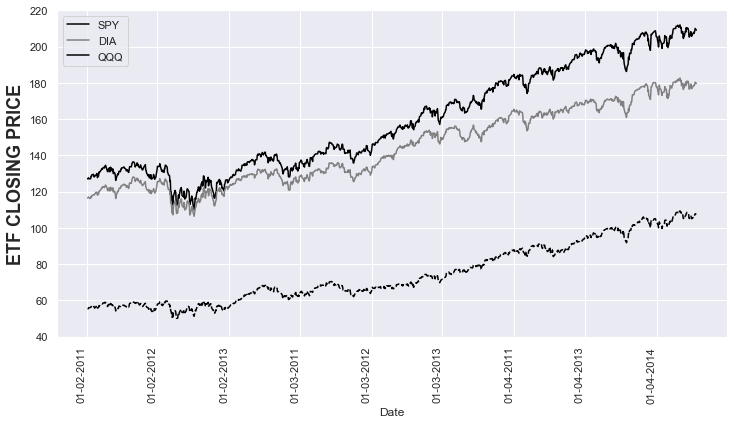

In [5]:
sns.set()

fig, ax = plt.subplots(figsize = (12,6))

fig = sns.lineplot(x=ETF_df.index, y='Close_spy', data=ETF_df, label="SPY", color='black')
sns.lineplot(x=ETF_df.index, y='Close_dia', data=ETF_df, label="DIA", color='grey')
sns.lineplot(x=ETF_df.index, y='Close_qqq', data=ETF_df, label="QQQ", color='black')

ax.lines[2].set_linestyle("--")

ax.set_ylabel('ETF CLOSING PRICE', fontsize=18, fontweight='bold')
ax.set(ylim=(40, 220))

x_dates = ETF_df.index.strftime('%d-%m-%Y').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=90, ha='right')

plt.savefig('table/Figure1.png')

# Table 2

In [ ]:
# With the return in 03 January 2011
Total_df = df.loc[('2010-12-31' <= df.index) & (df.index <= '2015-04-13')]

# With the first return in 04 January 2011
Total_df = df.loc[('2011-
                   01-03' <= df.index) & (df.index <= '2015-04-13')]

* Focus on DIA

In [60]:
dia = Total_df.iloc[:,:6].copy()
dia

,Open_dia,High_dia,Low_dia,Close_dia,Adj Close_dia,Volume_dia
Date,,,,,,
2010-12-31,115.320000,115.730003,115.040001,115.629997,93.069496,3725200
2011-01-03,116.410004,116.860001,116.360001,116.410004,93.697350,9108900
2011-01-04,116.709999,116.730003,116.110001,116.639999,93.882401,9775600
2011-01-05,116.459999,117.190002,116.300003,117.040001,94.204399,7567800
2011-01-06,117.139999,117.190002,116.500000,116.779999,93.995064,7161600
...,...,...,...,...,...,...
2015-04-07,178.770004,179.580002,178.419998,178.419998,158.730667,6011600
2015-04-08,178.600006,179.559998,177.960007,178.750000,159.024261,4738500
2015-04-09,178.660004,179.630005,177.979996,179.399994,159.602463,4483800


In [63]:
# Calculating returns
dia["Open_dia_previous"] = dia["Open_dia"].shift(periods=1)
dia["Close_dia_previous"] = dia["Close_dia"].shift(periods=1)
dia["Adjusted_Close_dia_previous"] = dia["Adj Close_dia"].shift(periods=1)


# rt = (Pt - Pt-1)/Pt
dia["Open_return"] = (dia["Open_dia"] - dia["Open_dia_previous"])/(dia["Open_dia"])
dia["Close_return"] = (dia["Close_dia"] - dia["Close_dia_previous"])/(dia["Close_dia"])
dia["Adjusted_Close_return"] = (dia["Adj Close_dia"] - dia["Adjusted_Close_dia_previous"])/(dia["Adj Close_dia"])

# rt = ln(Pt) - ln(Pt-1)
dia["Open_log_return"] = np.log(dia["Open_dia"]) - np.log(dia["Open_dia_previous"])
dia["Close_log_return"] = np.log(dia["Close_dia"]) - np.log(dia["Close_dia_previous"])
dia["Adjusted_Close_log_return"] = np.log(dia["Adj Close_dia"]) - np.log(dia["Adjusted_Close_dia_previous"])

dia_stats = dia.iloc[1:,-6:].copy()
dia_stats

,Open_return,Close_return,Adjusted_Close_return,Open_log_return,Close_log_return,Adjusted_Close_log_return
Date,,,,,,
2011-01-03,0.009363,0.006701,0.006701,0.009408,0.006723,0.006723
2011-01-04,0.002570,0.001972,0.001971,0.002574,0.001974,0.001973
2011-01-05,-0.002147,0.003418,0.003418,-0.002144,0.003424,0.003424
2011-01-06,0.005805,-0.002226,-0.002227,0.005822,-0.002224,-0.002225
2011-01-07,-0.001967,-0.001801,-0.001801,-0.001965,-0.001800,-0.001800
...,...,...,...,...,...,...
2015-04-07,0.013705,-0.000953,-0.000952,0.013800,-0.000952,-0.000952
2015-04-08,-0.000952,0.001846,0.001846,-0.000951,0.001848,0.001848
2015-04-09,0.000336,0.003623,0.003623,0.000336,0.003630,0.003629


In [64]:
dia_Table2 = pd.DataFrame({'Mean':dia_stats.apply(np.mean),
                           'STD':dia_stats.apply(np.std),
                           'Skew':dia_stats.apply(skew),
                           'Fisher_Kurtosis':dia_stats.apply(kurtosis, args=(0, True)),
                           'Pearson_Kurtosis':dia_stats.apply(kurtosis, args=(0, False))})
dia_Table2                          

,Mean,STD,Skew,Fisher_Kurtosis,Pearson_Kurtosis
Open_return,0.000379,0.008479,-0.426765,3.513513,6.513513
Close_return,0.000370,0.008886,-0.588511,4.553029,7.553029
Adjusted_Close_return,0.000464,0.008879,-0.601148,4.591591,7.591591
Open_log_return,0.000415,0.008468,-0.359693,3.376253,6.376253
Close_log_return,0.000410,0.008869,-0.506940,4.338627,7.338627
Adjusted_Close_log_return,0.000503,0.008861,-0.519345,4.373145,7.373145


* Focus on QQQ

In [65]:
qqq = Total_df.iloc[:,6:12].copy()
qqq

,Open_qqq,High_qqq,Low_qqq,Close_qqq,Adj Close_qqq,Volume_qqq
Date,,,,,,
2010-12-31,54.590000,54.619999,54.209999,54.459999,49.398983,38540100
2011-01-03,54.970001,55.689999,54.950001,55.310001,50.170002,90994300
2011-01-04,55.509998,55.549999,54.919998,55.270000,50.133709,43851500
2011-01-05,55.099998,55.759998,55.070000,55.740002,50.560024,43787400
2011-01-06,55.799999,55.959999,55.680000,55.919998,50.723312,46139600
...,...,...,...,...,...,...
2015-04-07,105.919998,106.699997,105.800003,105.800003,100.975021,19379400
2015-04-08,105.839996,106.790001,105.830002,106.639999,101.776711,25866900
2015-04-09,106.589996,107.349998,106.230003,107.309998,102.416145,23114700


In [66]:
# Calculating returns
qqq["Open_qqq_previous"] = qqq["Open_qqq"].shift(periods=1)
qqq["Close_qqq_previous"] = qqq["Close_qqq"].shift(periods=1)
qqq["Adjusted_Close_qqq_previous"] = qqq["Adj Close_qqq"].shift(periods=1)


# rt = (Pt - Pt-1)/Pt
qqq["Open_return"] = (qqq["Open_qqq"] - qqq["Open_qqq_previous"])/(qqq["Open_qqq"])
qqq["Close_return"] = (qqq["Close_qqq"] - qqq["Close_qqq_previous"])/(qqq["Close_qqq"])
qqq["Adjusted_Close_return"] = (qqq["Adj Close_qqq"] - qqq["Adjusted_Close_qqq_previous"])/(qqq["Adj Close_qqq"])

# rt = ln(Pt) - ln(Pt-1)
qqq["Open_log_return"] = np.log(qqq["Open_qqq"]) - np.log(qqq["Open_qqq_previous"])
qqq["Close_log_return"] = np.log(qqq["Close_qqq"]) - np.log(qqq["Close_qqq_previous"])
qqq["Adjusted_Close_log_return"] = np.log(qqq["Adj Close_qqq"]) - np.log(qqq["Adjusted_Close_qqq_previous"])

qqq_stats = qqq.iloc[1:,-6:].copy()
qqq_stats

,Open_return,Close_return,Adjusted_Close_return,Open_log_return,Close_log_return,Adjusted_Close_log_return
Date,,,,,,
2011-01-03,0.006913,0.015368,0.015368,0.006937,0.015487,0.015487
2011-01-04,0.009728,-0.000724,-0.000724,0.009776,-0.000723,-0.000724
2011-01-05,-0.007441,0.008432,0.008432,-0.007413,0.008468,0.008468
2011-01-06,0.012545,0.003219,0.003219,0.012624,0.003224,0.003224
2011-01-07,0.003927,-0.000895,-0.000895,0.003935,-0.000895,-0.000895
...,...,...,...,...,...,...
2015-04-07,0.013406,-0.001701,-0.001701,0.013497,-0.001700,-0.001700
2015-04-08,-0.000756,0.007877,0.007877,-0.000756,0.007908,0.007908
2015-04-09,0.007036,0.006244,0.006243,0.007061,0.006263,0.006263


In [67]:
qqq_Table2 = pd.DataFrame({'Mean':qqq_stats.apply(np.mean),
                           'STD':qqq_stats.apply(np.std),
                           'Skew':qqq_stats.apply(skew),
                           'Fisher_Kurtosis':qqq_stats.apply(kurtosis, args=(0, True)),
                           'Pearson_Kurtosis':qqq_stats.apply(kurtosis, args=(0, False))})
qqq_Table2                          

,Mean,STD,Skew,Fisher_Kurtosis,Pearson_Kurtosis
Open_return,0.000579,0.010414,-0.505064,2.266749,5.266749
Close_return,0.000577,0.010553,-0.476806,3.308801,6.308801
Adjusted_Close_return,0.000624,0.010545,-0.484812,3.330103,6.330103
Open_log_return,0.000633,0.010395,-0.442710,2.187687,5.187687
Close_log_return,0.000632,0.010536,-0.397385,3.146702,6.146702
Adjusted_Close_log_return,0.000680,0.010528,-0.405240,3.166030,6.166030


* focus on SPY

In [68]:
spy = Total_df.iloc[:,-6:].copy()
spy

,Open_spy,High_spy,Low_spy,Close_spy,Adj Close_spy,Volume_spy
Date,,,,,,
2010-12-31,125.529999,125.870003,125.330002,125.750000,104.364723,91218900
2011-01-03,126.709999,127.599998,125.699997,127.050003,105.443665,138725200
2011-01-04,127.330002,127.370003,126.190002,126.980003,105.385559,137409700
2011-01-05,126.580002,127.720001,126.459999,127.639999,105.933296,133975300
2011-01-06,127.690002,127.830002,127.010002,127.389999,105.725830,122519000
...,...,...,...,...,...,...
2015-04-07,207.860001,208.759995,207.240005,207.279999,187.571274,81236300
2015-04-08,207.550003,208.509995,207.080002,207.979996,188.204712,89351900
2015-04-09,207.779999,209.179993,207.190002,208.899994,189.037262,85548900


In [69]:
# Calculating returns
spy["Open_spy_previous"] = spy["Open_spy"].shift(periods=1)
spy["Close_spy_previous"] = spy["Close_spy"].shift(periods=1)
spy["Adjusted_Close_spy_previous"] = spy["Adj Close_spy"].shift(periods=1)


# rt = (Pt - Pt-1)/Pt
spy["Open_return"] = (spy["Open_spy"] - spy["Open_spy_previous"])/(spy["Open_spy"])
spy["Close_return"] = (spy["Close_spy"] - spy["Close_spy_previous"])/(spy["Close_spy"])
spy["Adjusted_Close_return"] = (spy["Adj Close_spy"] - spy["Adjusted_Close_spy_previous"])/(spy["Adj Close_spy"])

# rt = ln(Pt) - ln(Pt-1)
spy["Open_log_return"] = np.log(spy["Open_spy"]) - np.log(spy["Open_spy_previous"])
spy["Close_log_return"] = np.log(spy["Close_spy"]) - np.log(spy["Close_spy_previous"])
spy["Adjusted_Close_log_return"] = np.log(spy["Adj Close_spy"]) - np.log(spy["Adjusted_Close_spy_previous"])

spy_stats = spy.iloc[1:,-6:].copy()
spy_stats

,Open_return,Close_return,Adjusted_Close_return,Open_log_return,Close_log_return,Adjusted_Close_log_return
Date,,,,,,
2011-01-03,0.009313,0.010232,0.010232,0.009356,0.010285,0.010285
2011-01-04,0.004869,-0.000551,-0.000551,0.004881,-0.000551,-0.000551
2011-01-05,-0.005925,0.005171,0.005171,-0.005908,0.005184,0.005184
2011-01-06,0.008693,-0.001962,-0.001962,0.008731,-0.001961,-0.001960
2011-01-07,-0.001019,-0.001966,-0.001966,-0.001019,-0.001964,-0.001964
...,...,...,...,...,...,...
2015-04-07,0.011979,-0.002653,-0.002654,0.012052,-0.002650,-0.002650
2015-04-08,-0.001494,0.003366,0.003366,-0.001492,0.003371,0.003371
2015-04-09,0.001107,0.004404,0.004404,0.001108,0.004414,0.004414


In [70]:
spy_Table2 = pd.DataFrame({'Mean':spy_stats.apply(np.mean),
                           'STD':spy_stats.apply(np.std),
                           'Skew':spy_stats.apply(skew),
                           'Fisher_Kurtosis':spy_stats.apply(kurtosis, args=(0, True)),
                           'Pearson_Kurtosis':spy_stats.apply(kurtosis, args=(0, False))})
spy_Table2                          

,Mean,STD,Skew,Fisher_Kurtosis,Pearson_Kurtosis
Open_return,0.000434,0.009337,-0.450456,4.180738,7.180738
Close_return,0.000427,0.009630,-0.651561,5.489105,8.489105
Adjusted_Close_return,0.000507,0.009615,-0.670599,5.552258,8.552258
Open_log_return,0.000478,0.009324,-0.367673,4.016544,7.016544
Close_log_return,0.000473,0.009607,-0.551436,5.175109,8.175109
Adjusted_Close_log_return,0.000553,0.009593,-0.570082,5.233316,8.233316


* Method 1 : Using Open data

In [96]:
Total_open_df = Total_df[['Open_dia', 'Open_qqq', 'Open_spy']].copy()
Total_open_df[['prev_Open_dia', 'prev_Open_qqq', 'prev_Open_spy']] = Total_open_df[['Open_dia', 'Open_qqq', 'Open_spy']].shift(periods=1)

Total_open_df['DIA'] = (Total_open_df['Open_dia'] - Total_open_df['prev_Open_dia']) / Total_open_df['Open_dia']
Total_open_df['QQQ'] = (Total_open_df['Open_qqq'] - Total_open_df['prev_Open_qqq']) / Total_open_df['Open_qqq']
Total_open_df['SPY'] = (Total_open_df['Open_spy'] - Total_open_df['prev_Open_spy']) / Total_open_df['Open_spy']

Open_stats_df = Total_open_df.iloc[1:,-3:].copy()
# Open_stats_df

Open_Table2 = pd.DataFrame({'Mean':Open_stats_df.apply(np.mean),
                           'STD':Open_stats_df.apply(np.std),
                           'Skew':Open_stats_df.apply(skew),
                           'Fisher_Kurtosis':Open_stats_df.apply(kurtosis, args=(0, True)),
                           'Pearson_Kurtosis':Open_stats_df.apply(kurtosis, args=(0, False))})
Open_Table2.transpose()

,DIA,QQQ,SPY
Mean,0.000379,0.000579,0.000434
STD,0.008479,0.010414,0.009337
Skew,-0.426765,-0.505064,-0.450456
Fisher_Kurtosis,3.513513,2.266749,4.180738
Pearson_Kurtosis,6.513513,5.266749,7.180738


In [99]:
Total_open_df['DIA'] = np.log(Total_open_df['Open_dia']) - np.log(Total_open_df['prev_Open_dia'])
Total_open_df['QQQ'] = np.log(Total_open_df['Open_qqq']) - np.log(Total_open_df['prev_Open_qqq'])
Total_open_df['SPY'] = np.log(Total_open_df['Open_spy']) - np.log(Total_open_df['prev_Open_spy'])

Open_stats_df = Total_open_df.iloc[1:,-3:].copy()
# Open_stats_df

Open_Table2_bis = pd.DataFrame({'Mean':Open_stats_df.apply(np.mean),
                           'STD':Open_stats_df.apply(np.std),
                           'Skew':Open_stats_df.apply(skew),
                           'Fisher_Kurtosis':Open_stats_df.apply(kurtosis, args=(0, True)),
                           'Pearson_Kurtosis':Open_stats_df.apply(kurtosis, args=(0, False))})
Open_Table2_bis.transpose()

,DIA,QQQ,SPY
Mean,0.000415,0.000633,0.000478
STD,0.008468,0.010395,0.009324
Skew,-0.359693,-0.442710,-0.367673
Fisher_Kurtosis,3.376253,2.187687,4.016544
Pearson_Kurtosis,6.376253,5.187687,7.016544


* Method 2 : Using Close data

In [97]:
Total_close_df = Total_df[['Close_dia', 'Close_qqq', 'Close_spy']].copy()
Total_close_df[['prev_Close_dia', 'prev_Close_qqq', 'prev_Close_spy']] = Total_close_df[['Close_dia', 'Close_qqq', 'Close_spy']].shift(periods=1)

Total_close_df['DIA'] = (Total_close_df['Close_dia'] - Total_close_df['prev_Close_dia']) / Total_close_df['Close_dia']
Total_close_df['QQQ'] = (Total_close_df['Close_qqq'] - Total_close_df['prev_Close_qqq']) / Total_close_df['Close_qqq']
Total_close_df['SPY'] = (Total_close_df['Close_spy'] - Total_close_df['prev_Close_spy']) / Total_close_df['Close_spy']

Close_stats_df = Total_close_df.iloc[1:,-3:].copy()
# Close_stats_df

Close_Table2 = pd.DataFrame({'Mean':Close_stats_df.apply(np.mean),
                           'STD':Close_stats_df.apply(np.std),
                           'Skew':Close_stats_df.apply(skew),
                           'Fisher_Kurtosis':Close_stats_df.apply(kurtosis, args=(0, True)),
                           'Pearson_Kurtosis':Close_stats_df.apply(kurtosis, args=(0, False))})
Close_Table2.transpose()

,DIA,QQQ,SPY
Mean,0.000370,0.000577,0.000427
STD,0.008886,0.010553,0.009630
Skew,-0.588511,-0.476806,-0.651561
Fisher_Kurtosis,4.553029,3.308801,5.489105
Pearson_Kurtosis,7.553029,6.308801,8.489105


In [100]:
Total_close_df['DIA'] = np.log(Total_close_df['Close_dia']) - np.log(Total_close_df['prev_Close_dia'])
Total_close_df['QQQ'] = np.log(Total_close_df['Close_qqq']) - np.log(Total_close_df['prev_Close_qqq'])
Total_close_df['SPY'] = np.log(Total_close_df['Close_spy']) - np.log(Total_close_df['prev_Close_spy'])

Close_stats_df = Total_close_df.iloc[1:,-3:].copy()
# Close_stats_df

Close_Table2_bis = pd.DataFrame({'Mean':Close_stats_df.apply(np.mean),
                           'STD':Close_stats_df.apply(np.std),
                           'Skew':Close_stats_df.apply(skew),
                           'Fisher_Kurtosis':Close_stats_df.apply(kurtosis, args=(0, True)),
                           'Pearson_Kurtosis':Close_stats_df.apply(kurtosis, args=(0, False))})
Close_Table2_bis.transpose()

,DIA,QQQ,SPY
Mean,0.000410,0.000632,0.000473
STD,0.008869,0.010536,0.009607
Skew,-0.506940,-0.397385,-0.551436
Fisher_Kurtosis,4.338627,3.146702,5.175109
Pearson_Kurtosis,7.338627,6.146702,8.175109


* Method 3 : Using Adjusted close

In [98]:
Total_adj_close_df = Total_df[['Adj Close_dia', 'Adj Close_qqq', 'Adj Close_spy']].copy()
Total_adj_close_df[['prev_adj_Close_dia', 'prev_adj_Close_qqq', 'prev_adj_Close_spy']] = Total_adj_close_df[['Adj Close_dia', 'Adj Close_qqq', 'Adj Close_spy']].shift(periods=1)

Total_adj_close_df['DIA'] = (Total_adj_close_df['Adj Close_dia'] - Total_adj_close_df['prev_adj_Close_dia']) / Total_adj_close_df['Adj Close_dia']
Total_adj_close_df['QQQ'] = (Total_adj_close_df['Adj Close_qqq'] - Total_adj_close_df['prev_adj_Close_qqq']) / Total_adj_close_df['Adj Close_qqq']
Total_adj_close_df['SPY'] = (Total_adj_close_df['Adj Close_spy'] - Total_adj_close_df['prev_adj_Close_spy']) / Total_adj_close_df['Adj Close_spy']

Adj_close_stats_df = Total_adj_close_df.iloc[1:,-3:].copy()
# Adj_close_stats_df

Adj_close_Table2 = pd.DataFrame({'Mean':Adj_close_stats_df.apply(np.mean),
                           'STD':Adj_close_stats_df.apply(np.std),
                           'Skew':Adj_close_stats_df.apply(skew),
                           'Fisher_Kurtosis':Adj_close_stats_df.apply(kurtosis, args=(0, True)),
                           'Pearson_Kurtosis':Adj_close_stats_df.apply(kurtosis, args=(0, False))})
Adj_close_Table2.transpose()

,DIA,QQQ,SPY
Mean,0.000464,0.000624,0.000507
STD,0.008879,0.010545,0.009615
Skew,-0.601148,-0.484812,-0.670599
Fisher_Kurtosis,4.591591,3.330103,5.552258
Pearson_Kurtosis,7.591591,6.330103,8.552258


In [101]:
Total_adj_close_df['DIA'] = np.log(Total_adj_close_df['Adj Close_dia']) - np.log(Total_adj_close_df['prev_adj_Close_dia'])
Total_adj_close_df['QQQ'] = np.log(Total_adj_close_df['Adj Close_qqq']) - np.log(Total_adj_close_df['prev_adj_Close_qqq'])
Total_adj_close_df['SPY'] = np.log(Total_adj_close_df['Adj Close_spy']) - np.log(Total_adj_close_df['prev_adj_Close_spy'])

Adj_close_stats_df = Total_adj_close_df.iloc[1:,-3:].copy()
# Adj_close_stats_df

Adj_close_Table2_bis = pd.DataFrame({'Mean':Adj_close_stats_df.apply(np.mean),
                           'STD':Adj_close_stats_df.apply(np.std),
                           'Skew':Adj_close_stats_df.apply(skew),
                           'Fisher_Kurtosis':Adj_close_stats_df.apply(kurtosis, args=(0, True)),
                           'Pearson_Kurtosis':Adj_close_stats_df.apply(kurtosis, args=(0, False))})
Adj_close_Table2_bis.transpose()

,DIA,QQQ,SPY
Mean,0.000503,0.000680,0.000553
STD,0.008861,0.010528,0.009593
Skew,-0.519345,-0.405240,-0.570082
Fisher_Kurtosis,4.373145,3.166030,5.233316
Pearson_Kurtosis,7.373145,6.166030,8.233316


# Table 3

In [7]:
# Table 3
datasets = ["Total data-set", "Training data-set", "Test data-set", "Out-of-sample data-set"]
trading_days = [len(Total_df), len(Training_df), len(Test_df), len(Out_of_sample_df)]
start_date = [Total_df.index[0].strftime('%d/%m/%Y'), Training_df.index[0].strftime('%d/%m/%Y'), Test_df.index[0].strftime('%d/%m/%Y'), Out_of_sample_df.index[0].strftime('%d/%m/%Y')]
end_date = [Total_df.index[-1].strftime('%d/%m/%Y'), Training_df.index[-1].strftime('%d/%m/%Y'), Test_df.index[-1].strftime('%d/%m/%Y'), Out_of_sample_df.index[-1].strftime('%d/%m/%Y')]

Table3 = pd.DataFrame({"Datasets":datasets, "Trading days":trading_days, "Start date":start_date, "End date": end_date})

Table3.to_csv("table/Table3.csv", index=False)
Table3

,Datasets,Trading days,Start date,End date
0,Total data-set,1075,03/01/2011,13/04/2015
1,Training data-set,502,03/01/2011,31/12/2012
2,Test data-set,252,02/01/2013,31/12/2013
3,Out-of-sample data-set,321,02/01/2014,13/04/2015
